**Identify Yours Digit Dataset**

### 1. Problem understanding, Data Import, EDA

### Problem statement-
we need to identify the digit in given images. We have total 70,000 images, out of which 49,000 are part of train images with the label of digit and rest 21,000 images are unlabeled (known as test images). Now, We need to identify the digit for test images.


**Perform standard imports and load datasets**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.simplefilter('ignore')

import cv2
import glob
import os

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Convolution2D, BatchNormalization, Activation
from keras import regularizers, optimizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


**Datasets**

1. train.csv: training set containing the label and image name and images are in Images folder
2. test.csv : the set to make predictions over
3. sample_submission.csv : example of submission csv format for the competition

Metric: accuracy of the classification (% of right predictions)

**Unzipping folder which contains train and test images folders and train.csv file**

In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/Train_123.zip"

Archive:  /content/drive/My Drive/Colab Notebooks/Train_123.zip
replace Images/test/49000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Data Preparation**

In [ ]:
#readin train file
train = pd.read_csv('train.csv')
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


In [ ]:
#info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  49000 non-null  object
 1   label     49000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 765.8+ KB


In [ ]:
#reading test file
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")
test.head()

,filename
0,49000.png
1,49001.png
2,49002.png
3,49003.png
4,49004.png


In [ ]:
#info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  21000 non-null  object
dtypes: object(1)
memory usage: 164.2+ KB


In [ ]:
# summary of test and train data
train.describe()

,label
count,49000.000000
mean,4.452408
std,2.890206
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


In [ ]:
test.describe()

,filename
count,21000
unique,21000
top,63060.png
freq,1


In [ ]:
y_train = train['label']
x_train = train.drop('label',axis=1)

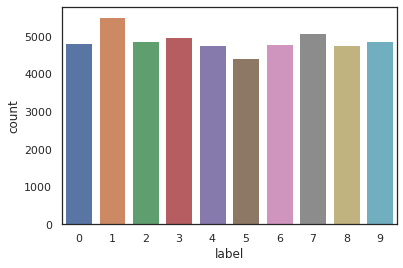

In [ ]:
# Distribution of Digits in the dataset
sns.countplot(y_train)

**Checking data for any null values**

In [ ]:
x_train.isnull().any().describe()

count         1
unique        1
top       False
freq          1
dtype: object

In [ ]:
test.isnull().any().describe()

count         1
unique        1
top       False
freq          1
dtype: object

In [ ]:
y_train.isnull().sum()

0

Therefor there is no null value in the dataset

**Function to load images in numpy array**

In [ ]:
def image_load(filepath):
    i_cv=[]
    for img in sorted(glob.glob(os.path.join(filepath,'*.png')),key=lambda x:int(x.split('/')[-1].split('.')[0])):
        cv_img = cv2.imread(img,0)
        i_cv.append(cv_img)
    x_train = np.array(i_cv)
    return x_train

In [ ]:
# loading training images
x_train = image_load('Images/train')

In [ ]:
#loading testing images
x_test = image_load('Images/test')

In [ ]:
print(f'Train data shape : {x_train.shape}')
print(f'Test data shape : {x_test.shape}')

Train data shape : (49000, 28, 28)
Test data shape : (21000, 28, 28)


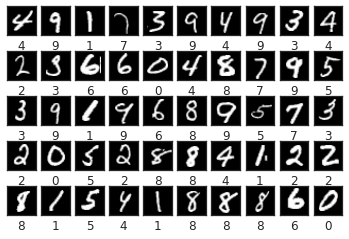

In [ ]:
#display training images and labels to make sure they lineup correctly

fig,ax = plt.subplots(5,10)
for i, axis in enumerate(ax.flat):
    axis.imshow(x_train[i], cmap= 'gray')
    axis.set(xticks = [], yticks=[], xlabel=y_train[i])

In [ ]:
#Analysis of pixel intensity values
pixels = pd.DataFrame(x_train.reshape(49000, 784))
pixels.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.000000,49000.000000,49000.000000,49000.000000,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,...,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.0,49000.000000,49000.000000,49000.000000,49000.00000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.0,49000.0,49000.0,49000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002571,0.009612,0.004429,0.000184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000327,0.001122,0.011286,0.028102,0.048163,0.074143,0.126469,0.180816,...,3.653367,2.674592,1.750408,1.077980,0.591286,0.263694,0.086306,0.023898,0.000612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004755,0.035000,0.101571,0.14202,0.218000,0.304143,0.381388,0.487224,0.581082,0.656041,0.608122,0.485082,0.315000,0.191184,0.092041,0.048633,0.019673,0.008857,0.001265,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525977,1.509174,0.980306,0.040658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072281,0.215377,1.163107,2.301728,3.117011,3.648989,4.914521,5.854156,...,26.504976,22.584546,18.263664,14.390402,10.774209,6.919345,3.755714,1.819320,0.102817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.838665,2.323923,4.398865,5.01387,6.570063,7.200749,8.561542,9.471211,10.487697,11.072890,10.713339,9.594891,7.627077,5.993740,4.010428,2.939762,1.802607,1.246969,0.280087,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00

-> Some of the pixels have always an intensity of 0 (max=0) or 255 (min=255)

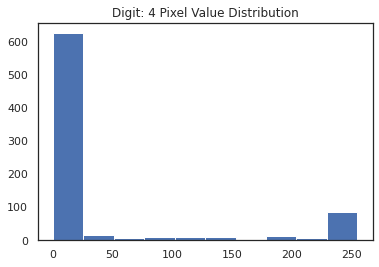

In [ ]:
plt.hist(pixels.iloc[0])
plt.title(f"Digit: {y_train[0]} Pixel Value Distribution")
plt.show()

As expected, the pixel values range from 0 to 255: the background majority close to 0, and those close to 255 representing the digit.

**Examining the randomness of dataset**

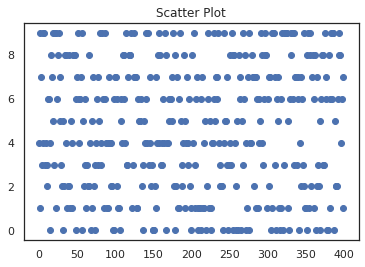

In [ ]:
plt.scatter(list(range(400)),y_train[:400])
plt.title('Scatter Plot')
plt.show()

Visualize the data with the help of one of the Dimensionality Reduction techniques, namely Principal Component Analysis (PCA)

We keep two components to make sure to have two-dimensional data to plot. This is to investigate if the PCA reveals the distribution of the different labels and if you can clearly separate the instances from each other.

In [ ]:
from sklearn.decomposition import PCA

# Create a  PCA model that takes two components
pca = PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(pixels)

# Inspect the shape
reduced_data_pca.shape

# Print out the data
print(reduced_data_pca)

[[ 186.91256062  550.23434659]
 [-318.38660971  590.89348248]
 [-868.34980018 -223.79613209]
 ...
 [-320.17594246  484.75907688]
 [-152.30010914 -437.32765759]
 [ 853.23396546 -102.26747004]]


**Building a scatterplot to visualize the data:**

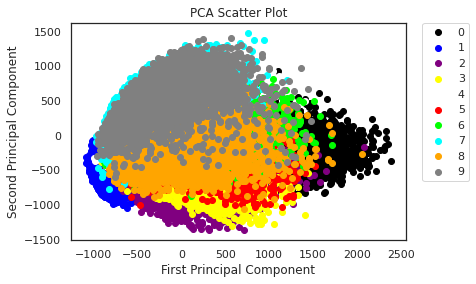

In [ ]:
from sklearn.decomposition import PCA

colors = ['black', 'blue', 'purple', 'yellow', 'white', 'red', 'lime', 'cyan', 'orange', 'gray']
for i in range(len(colors)):
    x = reduced_data_pca[:, 0][y_train == i]
    y = reduced_data_pca[:, 1][y_train == i]
    plt.scatter(x, y, c=colors[i])
plt.legend(sorted(train.label.unique()), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

Now we have even more information about the data and have a visualization ready, it does seem a bit like the data points sort of group together, but you also see there is quite some overlap.

**Feature Engineering**

In [ ]:
x_train = x_train.reshape(49000, 28,28,1)
x_test = x_test.reshape(21000, 28,28, 1)

In [ ]:
# Converting data to higher precision
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
# normalizing the data to help with the training
x_train = x_train/255.0
x_test = x_test/255.0

One hot Encoding using keras numpy-related utilities

In [ ]:
print("Shape before one-hot encoding: ", y_train.shape)
ytrain = to_categorical(y_train)
print("Shape after one-hot encoding: ", ytrain.shape)

Shape before one-hot encoding:  (49000,)
Shape after one-hot encoding:  (49000, 10)


In [ ]:
#checking shape of training and test dataset
print ("x_train:=====> {}".format(x_train.shape))
print ("ytrain:=====> {}".format(ytrain.shape))
print ("x_test: =====> {}".format(x_test.shape))

x_train:=====> (49000, 28, 28, 1)
ytrain:=====> (49000, 10)
x_test: =====> (21000, 28, 28, 1)


**Data Visualization**

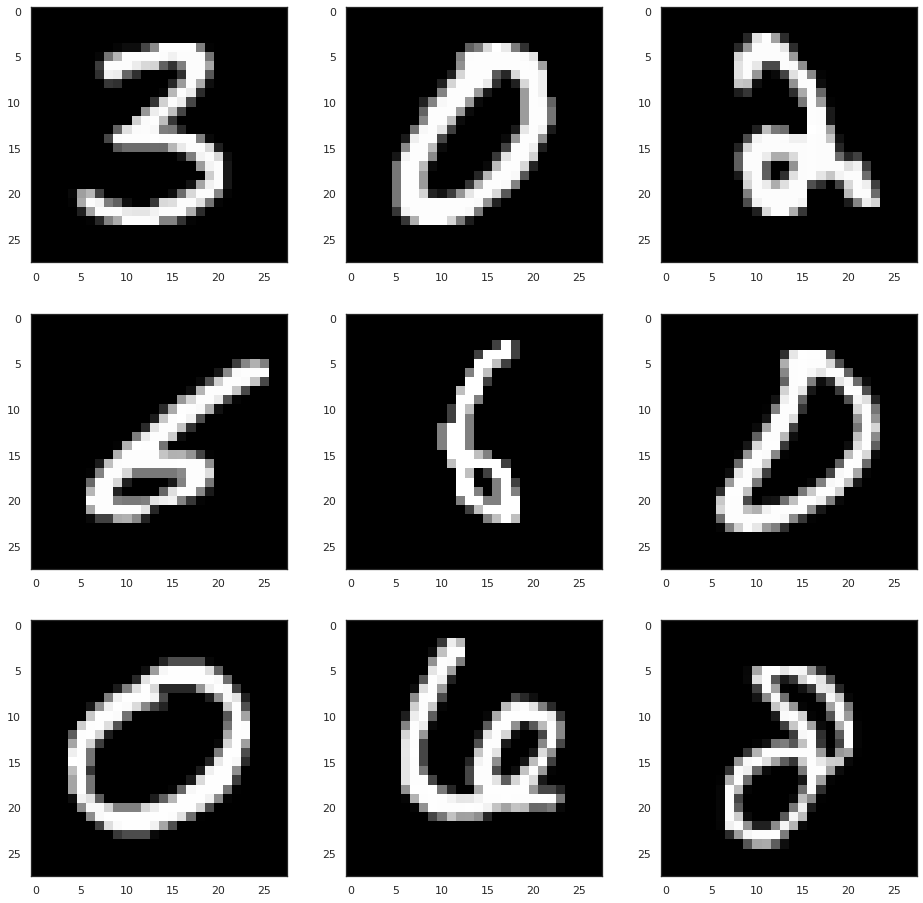

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(1,10):
  rand_num = random.randint(0,25000)
  fig.add_subplot(3,3,i)
  img_number = plt.imshow(x_train[rand_num][:,:,0],cmap='gray')

**Building the model**

**Convolution Neural Networks**



*  CNN is used for image classification, object detection

   ![alt text](https://preview.ibb.co/nRkBpp/gec2.jpg)



**Create Model :-**
1. conv => max pool => dropout => conv => max pool => dropout => fully  connected (2 layer)
2. Dropout: Dropout is a technique where randomly selected neurons are ignored during training

1. **Padding** :- Padding actually improves performance by keeping    information at the borders.
2. **Max Pooling** :- It makes down-sampling or sub-sampling (Reduces the number of parameters)
  
  -It makes the detection of features invariant to scale or orientation changes.

  -It reduce the amount of parameters and computation in the network, and hence to also control overfitting.
3. **Flattening** :-

     ![alt text](https://image.ibb.co/c7eVvU/flattenigng.jpg)

In [ ]:
# Initialising the CNN
model = Sequential()

# Step 1 - 1st Convolution Layer
model.add(Convolution2D(28, (5,5), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(28,(5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# Step 2 - 2nd Convolution Layer
model.add(Convolution2D(32,(5,5), padding='same', input_shape=x_train[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(32,(5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Step 3 - Fully Connected
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 28)        728       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 28)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 28)        112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 28)        19628     
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 28)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 28)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 28)        0

**Compliling the model**

**Sgd Optimizer** :-
1. It’s a variant of Gradient Descent.
2. It tries to update the model’s parameters more frequently.
3. Requires less memory as no need to store values of loss functions.

In [ ]:
optimizer = optimizers.sgd(lr=0.1, decay=0, momentum=0, nesterov=False) # lr->learning rate
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
# we use categorical crossentropy because we multi class

**Training the model**

In [ ]:
history=model.fit(x_train,ytrain,epochs=10,validation_split=0.1,batch_size=30)

Epoch 1/10
1470/1470 [==============================] - 237s 161ms/step - loss: 0.2539 - accuracy: 0.9181 - val_loss: 0.0681 - val_accuracy: 0.9763
Epoch 2/10
1470/1470 [==============================] - 233s 159ms/step - loss: 0.0919 - accuracy: 0.9718 - val_loss: 0.0427 - val_accuracy: 0.9857
Epoch 3/10
1470/1470 [==============================] - 234s 159ms/step - loss: 0.0672 - accuracy: 0.9785 - val_loss: 0.0504 - val_accuracy: 0.9843
Epoch 4/10
1470/1470 [==============================] - 228s 155ms/step - loss: 0.0530 - accuracy: 0.9833 - val_loss: 0.0328 - val_accuracy: 0.9894
Epoch 5/10
1470/1470 [==============================] - 232s 158ms/step - loss: 0.0461 - accuracy: 0.9857 - val_loss: 0.0296 - val_accuracy: 0.9902
Epoch 6/10
1470/1470 [==============================] - 242s 164ms/step - loss: 0.0410 - accuracy: 0.9869 - val_loss: 0.0288 - val_accuracy: 0.9908
Epoch 7/10
1470/1470 [==============================] - 237s 161ms/step - loss: 0.0376 - accuracy: 0.9877 - val_

**Evaluate the model**


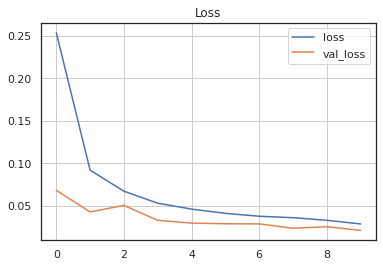

In [ ]:
# plot loss during training

plt.title('Loss')
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend(['loss','val_loss'])
plt.grid('on')
plt.show()

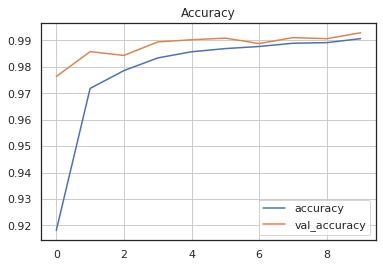

In [ ]:
# plot accuracy during training

plt.title('Accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(['accuracy','val_accuracy'])
plt.grid('on')
plt.show()

In [ ]:
# Saving the model
model_json = model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/model1.json","w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save('/content/drive/My Drive/Colab Notebooks/model1.h5')

**Prediction**

Actual label for 19682 observation is : 6


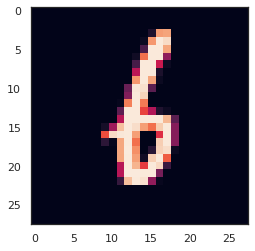

In [ ]:
result = model.predict(x_test)

predicted_classes = np.argmax(np.round(result),axis=1)

#Checking random predicted value if it's predicted correctly or not
print(f'Actual label for 19682 observation is : {predicted_classes[19682]}')
plt.imshow((tf.squeeze(x_test[19682])))

**Saving the test results to csv file**

In [ ]:
predicted_classes=pd.DataFrame(predicted_classes)
test_df=test.join(predicted_classes)
test_df.columns=['filename','label']
test_df.to_csv('/content/drive/My Drive/Colab Notebooks/Digits_Predictions_latest.csv',index=False)
test_df.head()

,filename,label
0,49000.png,4
1,49001.png,0
2,49002.png,9
3,49003.png,7
4,49004.png,9
